In [1]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [2]:
from pathlib import Path
from helper_functions import walk_through_dir

data_path=Path("data/")
image_path = data_path / "militaryvsother"
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\militaryvsother'.
There are 2 directories and 0 images in 'data\militaryvsother\test'.
There are 0 directories and 1281 images in 'data\militaryvsother\test\millitary'.
There are 0 directories and 1511 images in 'data\militaryvsother\test\other'.
There are 2 directories and 0 images in 'data\militaryvsother\train'.
There are 0 directories and 5125 images in 'data\militaryvsother\train\millitary'.
There are 0 directories and 6045 images in 'data\militaryvsother\train\other'.
There are 2 directories and 0 images in 'data\militaryvsother\validation'.
There are 0 directories and 1602 images in 'data\militaryvsother\validation\millitary'.
There are 0 directories and 1889 images in 'data\militaryvsother\validation\other'.


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/militaryvsother/train'),
 WindowsPath('data/militaryvsother/test'))

Random image path: data\militaryvsother\validation\millitary\millitary_0_614.jpeg
Image class: millitary
Image height: 256
Image width: 256


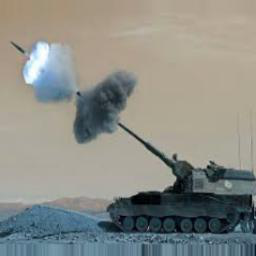

In [4]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

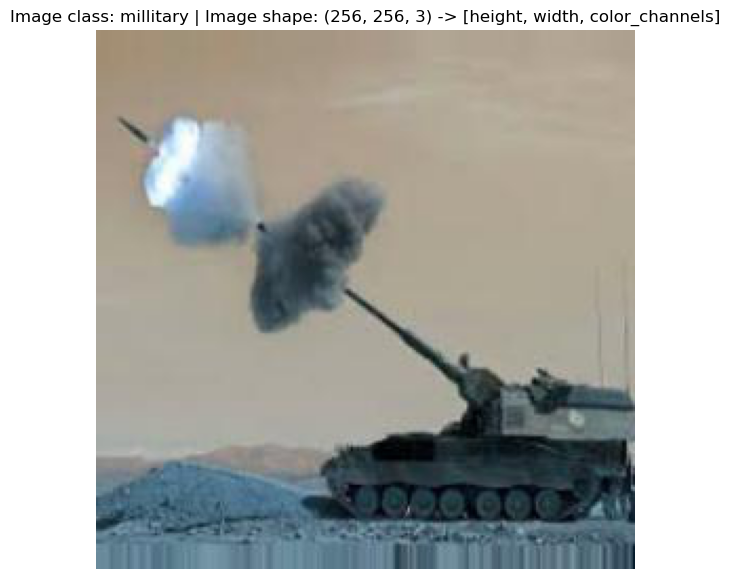

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transformer=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

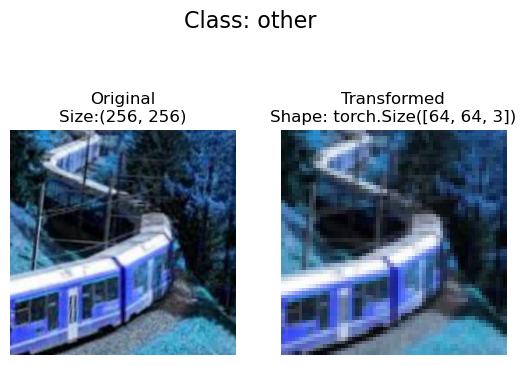

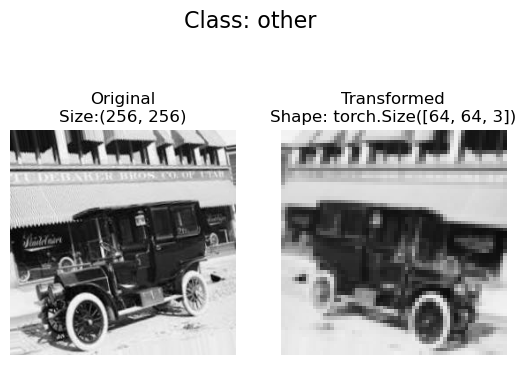

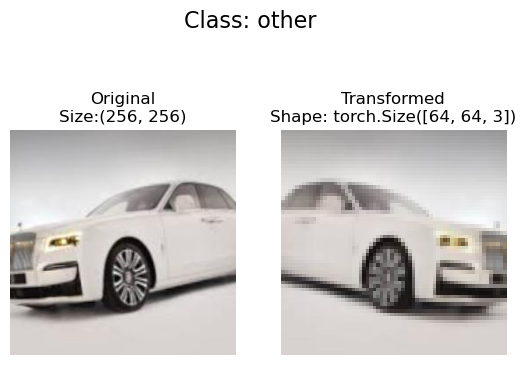

In [7]:
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list,transform=data_transformer)

In [8]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transformer,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transformer)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 11170
    Root location: data\militaryvsother\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 2792
    Root location: data\militaryvsother\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [9]:
#train data size, test data size and percentage of test to train
len(train_data),len(test_data),(len(test_data)/(len(train_data)+len(test_data))*100)

(11170, 2792, 19.997135080933965)

In [10]:
classes=train_data.classes
class_dict=train_data.class_to_idx
classes,class_dict

(['millitary', 'other'], {'millitary': 0, 'other': 1})

In [11]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=128
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True)


test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=NUM_WORKERS,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x23545caf850>,
 <torch.utils.data.dataloader.DataLoader at 0x235462f0160>)

In [13]:
from helper_functions import set_seeds
set_seeds()

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the DenseNet model
class DenseNetBinaryClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseNetBinaryClassifier, self).__init__()
        # Load the pre-trained DenseNet model
        densenet = models.densenet121(pretrained=True)
        
        # Remove the final classification layer
        self.features = densenet.features
        
        # Add a custom classifier for binary classification
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes),  # Adjust input size based on DenseNet variant used
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model = DenseNetBinaryClassifier()

# Optionally, print the model architecture
print(model)

c:\Users\TRON PCH\miniconda3\envs\ai_env2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TRON PCH\miniconda3\envs\ai_env2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\TRON PCH/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 36.0MB/s]

DenseNetBinaryClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru